# 生成图片
现在已经有训练好的style bank，利用style bank进行图片生成，并保存

In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import image_utils

from args import TrainArgs
import utils
from networks import LossNetwork, StyleBankNet
import numpy as np


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 当前目录
#current_directory = os.path.dirname(os.path.abspath(__file__))
current_directory = os.getcwd()


default_resource_dir = os.path.join(current_directory, "..", "Images")

# 原始图片目录
content_images_dir = os.path.join(default_resource_dir, 'original')
# 风格图片目录无所谓，测试阶段不用
style_dirname = "cartoon"
style_images_dir = os.path.join(default_resource_dir, style_dirname)
# 权重目录
model_dir = os.path.join(current_directory, "weights")
bank_subdir = "bank_cartoon"
# 输出图片目录
output_image_dir = os.path.join(current_directory, "output", style_dirname)

# 这里修改训练参数，不过这里只预测，不训练了
args = TrainArgs()
args.continue_training = False 
args.CONTENT_IMG_DIR = content_images_dir
args.STYLE_IMG_DIR = style_images_dir
args.SetModelWeightDir(model_dir)
args.SetNewBankWeightDir(bank_subdir)
# 默认1000
args.SetK(1)

device = args.device

d:\Program Files\Anaconda3\envs\pytorchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device:cuda:0
device:cuda:0


In [2]:
# 找出文件数量
style_filenames = os.listdir(args.NEW_BANK_WEIGHT_DIR)
style_num = len(style_filenames)

In [3]:
"""
加载style bank net，但是不用加载loss network了
"""
# 加载model
model = StyleBankNet(style_num).to(device)
# 读取encoder权重
if os.path.exists(args.ENCODER_WEIGHT_PATH):
    model.encoder_net.load_state_dict(torch.load(args.ENCODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')

# 读取decoder权重
if os.path.exists(args.DECODER_WEIGHT_PATH):
    model.decoder_net.load_state_dict(torch.load(args.DECODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')
# 文件名从0开始
for style_id in range(style_num):
    style_pt = args.NEW_BANK_WEIGHT_PATH.format(style_id)
    model.style_bank[style_id].load_state_dict(torch.load(style_pt))

# 全部eval模式
model.encoder_net.eval()
model.decoder_net.eval()
model.style_bank.eval()


ModuleList(
  (0): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

下面加载图片

In [4]:
content_dataset = image_utils.ImageFolder(root_path=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)


展示图片，第一个batch

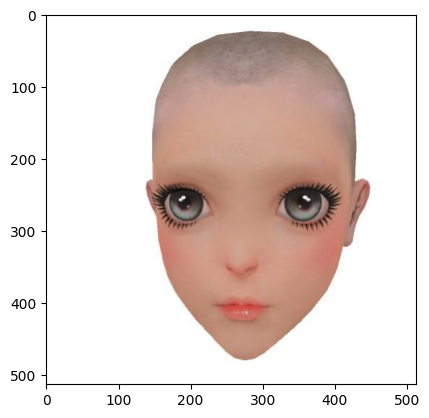

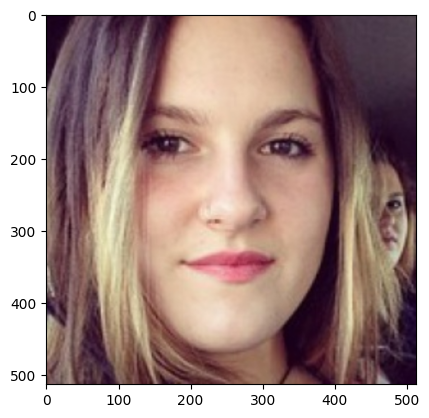

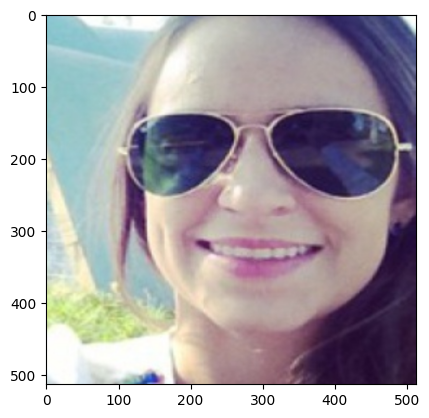

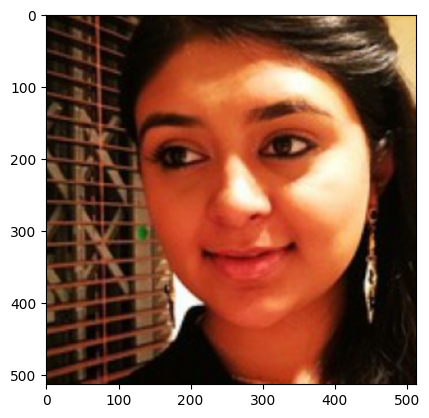

In [5]:
for imgs in content_dataloader:
    for i in range(args.batch_size):
        utils.showimg(imgs[i])
    break

进行风格化

In [6]:
allstyle_images = []
for style_idx in range(style_num):
    cur_styled_images = []
    for imgs in content_dataloader:
        style_ids = np.full((len(imgs),), style_idx)
        styled_image = model(imgs.to(device), style_ids)
        cur_styled_images.append(styled_image.cpu().detach())
    cur_styled_images = torch.concat(cur_styled_images)
    cur_styled_images = cur_styled_images.view(1, *cur_styled_images.shape)
    allstyle_images.append(cur_styled_images)
allstyle_images = torch.concat(allstyle_images)

In [7]:
#(style_id, content_image, 3, w, h)
allstyle_images.shape

torch.Size([10, 11, 3, 513, 513])

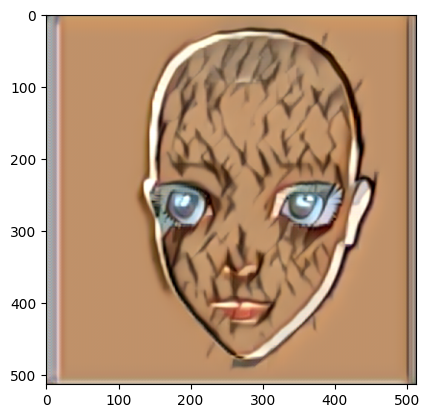

In [8]:
utils.showimg(allstyle_images[0][0].cpu().detach())

下面保存所有图片

In [9]:
content_filenames = sorted(os.listdir(content_images_dir))
style_filenames = sorted(os.listdir(style_images_dir))
content_idx = 0

for content_filename in content_filenames:
    split_tup = os.path.splitext(content_filename)
    contentname_prefix = split_tup[0]
    contentname_suffix = split_tup[1]
    image_dir = os.path.join(output_image_dir, contentname_prefix)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    style_idx = 0
    for style_filename in style_filenames:
        split_style = os.path.splitext(style_filename)
        stylename_prefix = split_style[0]
        filepath = os.path.join(image_dir, contentname_prefix + "_" + stylename_prefix + ".png")
        content = allstyle_images[style_idx][content_idx]
        print(content.shape)
        utils.saveimg(content,filepath)
        style_idx = style_idx + 1
    content_idx = content_idx + 1

torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([3, 513, 513])
torch.Size([

In [10]:
content.shape
content

tensor([[[0.5160, 0.5178, 0.4646,  ..., 0.4259, 0.4066, 0.3352],
         [0.5047, 0.5311, 0.5264,  ..., 0.3797, 0.3721, 0.3513],
         [0.5284, 0.6114, 0.5677,  ..., 0.3458, 0.3376, 0.3197],
         ...,
         [0.8233, 0.9529, 1.0625,  ..., 0.0867, 0.1101, 0.1027],
         [0.7715, 0.9039, 0.8782,  ..., 0.1136, 0.1349, 0.1332],
         [0.6365, 0.7677, 0.6467,  ..., 0.1552, 0.1681, 0.1626]],

        [[0.4575, 0.5021, 0.4790,  ..., 0.4071, 0.3979, 0.3542],
         [0.4538, 0.5029, 0.5202,  ..., 0.3670, 0.3702, 0.3723],
         [0.5143, 0.5408, 0.5383,  ..., 0.3436, 0.3346, 0.3518],
         ...,
         [0.7877, 0.8131, 0.8523,  ..., 0.1170, 0.1339, 0.1639],
         [0.6995, 0.7811, 0.8088,  ..., 0.1414, 0.1649, 0.1745],
         [0.6593, 0.7471, 0.8012,  ..., 0.2059, 0.2001, 0.1859]],

        [[0.5068, 0.5053, 0.4712,  ..., 0.3536, 0.3339, 0.3149],
         [0.4784, 0.4620, 0.4553,  ..., 0.3179, 0.3066, 0.3398],
         [0.5417, 0.5377, 0.5055,  ..., 0.2922, 0.2761, 0.